# Table of contents
1. [Initial Cleaning](#section-1)
2. [Normalizing Shark Species Information](#section-2)
2. [Checking data biase using sex of the vicitim](#section-3)
3. [Shark Lethality](#section-4)
4. [Shark Aggresivity](#section-5)
5. [Final Conclusions](#section-6)

In [1]:
# Libraries Import Section:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import src.cleaning as cl

In [2]:
# Saving images
""""
sharks_fatal4_graph.figure.savefig("./images/lethality.png", dpi=1000)
sharks_aggre3_graph.figure.savefig("./images/aggresivity.png", dpi=1000)
species_count.figure.savefig("./images/shark-species.png", dpi=1000)
"""

'"\nsharks_fatal4_graph.figure.savefig("./images/lethality.png", dpi=1000)\nsharks_aggre3_graph.figure.savefig("./images/aggresivity.png", dpi=1000)\nspecies_count.figure.savefig("./images/shark-species.png", dpi=1000)\n'

# Initial Cleaning<a name="section-1"></a>

- Remove blank lines and duplicates
- Remove columns without useful information for the study

### Initial Database Size:

In [3]:
# Importing Shark database, print initial database size and perform initial cleaning:
sharks = cl.import_clean("./data/sharks.csv", 'unicode_escape')

Rows: 25723
    Columns: 24


In [4]:
# droping some useless columns
sharks_species = sharks.drop(['Investigator or Source','pdf','href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order', 'Unnamed: 22',
       'Unnamed: 23'], axis=1)

### Database Size After Cleaning:

In [5]:
print(f"""Rows: {sharks_species.shape[0]}
Columns: {sharks_species.shape[1]}""")

Rows: 6311
Columns: 15


# Normalizing Shark Species Information:<a name="section-2"></a>
- Add Unknown Shark to all cases without information
- Find if Shark Species are metioned in the cases where something is reported
- Clean and standrize Shark Species reported
- Find the 8 species most reported and group the others in a Other Sharks category
- Adding a new column "Shark Identified"

In [6]:
sharks_species = cl.species_norm(sharks_species)

### Result:

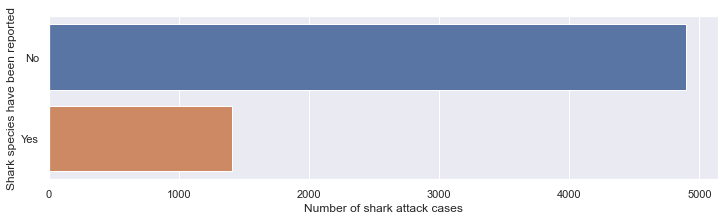

In [7]:
sns.set(rc={"figure.figsize": (12.,3.)})
identified_shark = sns.countplot(y="Shark Identified", data=sharks_species)
identified_shark.set_yticklabels(labels=["No", "Yes"])
identified_shark.set(xlabel="Number of shark attack cases", ylabel="Shark species have been reported")
plt.show()

In [8]:
sharks_species["Species "].value_counts()

Unknown Shark        4900
White Shark           429
Other Sharks          372
Tiger Shark           231
Bull Shark            128
Nurse Shark            52
Wobbegong Shark        45
Mako Shark             44
Raggedtooth Shark      42
Blacktip Shark         37
Lemon Shark            31
Name: Species , dtype: int64

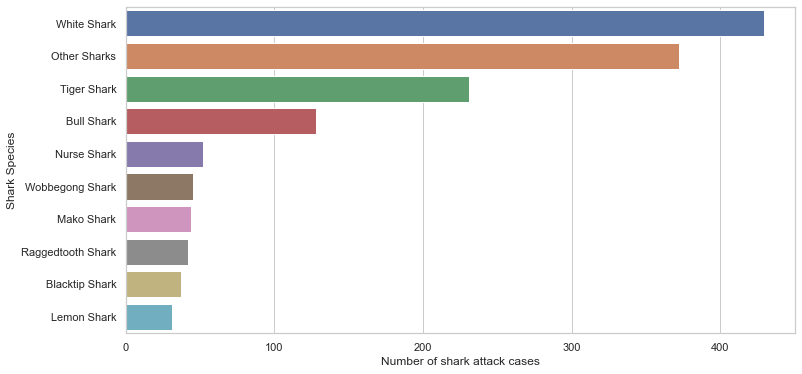

In [9]:
sharks_species_clean = sharks_species[sharks_species["Species "] != "Unknown Shark"]
sns.set_context("poster")
sns.set(rc={"figure.figsize": (12.,6.)})
sns.set_style("whitegrid")
species_count = sns.countplot(y="Species ", data=sharks_species_clean, order = sharks_species_clean['Species '].value_counts().index)
species_count.set(xlabel="Number of shark attack cases", ylabel="Shark Species")
plt.show()

## Conclusions:
* The number of incidents where the shark species was reported is around 30%
* The shark species whith more incidents reported are White Shark, Tiger Shark and Bull Shark
* Considering the small number of incidents where the shark species was reported it might be necessary to check for possible biased data between the incidents where the shark species was identified and not.

# Checking data biase using sex of the vicitim<a name="section-3"></a>
* The objective of this section is to pick an aprently unrelated variable (sex of the victim) and check if there is a diference between the incidents where the shark species was reported and not

In [10]:
## Cleaning Sex column in the dataframe
sharks_sex = cl.sex_clean(sharks_species)

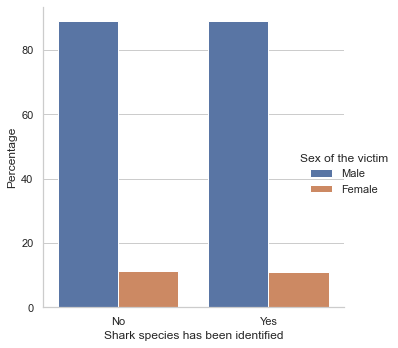

In [11]:
sharks_sex2 = sharks_sex.groupby("Shark Identified")["Sex "] ##grouping
sharks_sex2 = sharks_sex2.value_counts(normalize=True).mul(100) ##Getting the percentage
sharks_sex2 = sharks_sex2.rename("Percentage").reset_index()
sharks_sex2_graph =  sns.catplot(x="Shark Identified", y="Percentage", hue="Sex ", kind='bar', data=sharks_sex2)
sharks_sex2_graph.set(xlabel='Shark species has been identified', ylabel='Percentage')
sharks_sex2_graph.set_xticklabels(labels=["No", "Yes"])
sharks_sex2_graph._legend.set_title("Sex of the victim")
for t, l in zip(sharks_sex2_graph._legend.texts, ["Male", "Female"]):
    t.set_text(l)

## Conclusions:
* The percentage of each sex in the incidents where the shark species where reported and not is almost the same
* We can consider that each subset of the data has no biase

# Shark Lethality <a name="section-4"></a>
* Check possible bias between the incidents where the shark species was reported and not when the outcome of the incident is assessed
* Check different species lethality rate

In [12]:
## Normalizing and Cleaning Database for Fatal (Y/N) column
sharks_fatal = cl.fatal_clean(sharks_species)

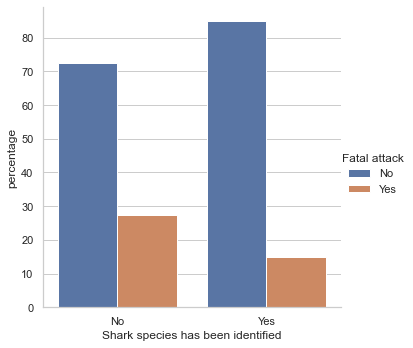

In [13]:
sharks_fatal2 = sharks_fatal.groupby("Shark Identified")["Fatal (Y/N)"] ##grouping
sharks_fatal2 = sharks_fatal2.value_counts(normalize=True).mul(100) ##Getting the percentage
sharks_fatal2 = sharks_fatal2.rename("Percentage").reset_index()
sharks_fatal2_graph =  sns.catplot(x="Shark Identified", y="Percentage", hue="Fatal (Y/N)", kind='bar', data=sharks_fatal2)
sharks_fatal2_graph.set(xlabel='Shark species has been identified', ylabel='percentage', label="Fatal attack")
sharks_fatal2_graph.set_xticklabels(labels=["No", "Yes"])
sharks_fatal2_graph._legend.set_title("Fatal attack")
for t, l in zip(sharks_fatal2_graph._legend.texts, ["No", "Yes"]):
    t.set_text(l)

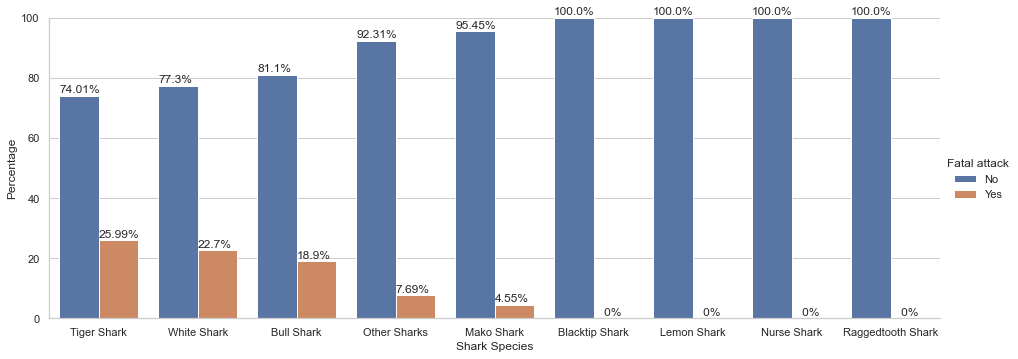

In [14]:
sharks_fatal3 = sharks_fatal[sharks_fatal["Species "] != "Unknown Shark"]
sharks_fatal3 = sharks_fatal.groupby("Species ")["Fatal (Y/N)"] ##grouping
sharks_fatal3 = sharks_fatal3.value_counts(normalize=True).mul(100) ##Getting the percentage
sharks_fatal3 = sharks_fatal3.rename("Percentage").reset_index()
sharks_fatal3_graph =  sns.catplot(x="Species ", y="Percentage", hue="Fatal (Y/N)", kind='bar', aspect=16/6, order=['Tiger Shark','White Shark','Bull Shark', 'Other Sharks', 'Mako Shark', "Blacktip Shark", "Lemon Shark", "Nurse Shark", "Raggedtooth Shark"], data=sharks_fatal3)
sharks_fatal3_graph.set(xlabel='Shark Species', ylabel='Percentage', label="Fatal attack")
sharks_fatal3_graph._legend.set_title("Fatal attack")
for t, l in zip(sharks_fatal3_graph._legend.texts, ["No", "Yes"]):
    t.set_text(l)
sharks_fatal3_graph.ax.set_ylim(0,100)
for p in sharks_fatal3_graph.ax.patches:
    x = p.get_x()
    y = p.get_height()
    if not y > 0:
        y = 0
        txt = '   0%'
    else:
        txt = str(p.get_height().round(2)) + '%'
    sharks_fatal3_graph.ax.text(x,y+1,txt)

## Normalizing data for biase in the data when shark species were reported

In [15]:
sharks_fatal4 = cl.norm_biase(sharks_fatal2, sharks_fatal3)

NameError: name 'norm_biase' is not defined

In [ ]:
sharks_fatal4_graph =  sns.catplot(x="Species ", y="Percentage", hue="Fatal (Y/N)", kind='bar', aspect=16/6, order=['Tiger Shark','White Shark','Bull Shark', 'Other Sharks', 'Mako Shark', "Blacktip Shark", "Lemon Shark", "Nurse Shark", "Raggedtooth Shark"], data=sharks_fatal4)
sharks_fatal4_graph.set(xlabel='Shark Species', ylabel='Percentage', label="Fatal attack")
sharks_fatal4_graph._legend.set_title("Fatal attack")
for t, l in zip(sharks_fatal4_graph._legend.texts, ["No", "Yes"]):
    t.set_text(l)
sharks_fatal4_graph.ax.set_ylim(0,100)
for p in sharks_fatal4_graph.ax.patches:
    x = p.get_x()
    y = p.get_height()
    if not y > 0:
        y = 0
        txt = '   0%'
    else:
        txt = str(p.get_height().round(2)) + '%'
    sharks_fatal4_graph.ax.text(x,y+1,txt)

## Conclusions:
* There is a small bias between the subset where the shark species was reported and the one that was not reported when we assess the outcome of the attack.
* The bias can be explained because **is more likely that the shark species is reported when the victim survives the attack**.
* The sharks with **highest lethality** are: **Tiger Shark, White Shark and Bull Shark**.

# Shark Aggressivity<a name="section-5"></a>
* To test for shark aggresivity the inicidents that reported aw "Unprovoked" incident or "Provoked" inicident were used. Other type of inicidents were descarted as it is difficult to assess if were provoked or not.

* The type of inicident was then evaluated in each one of the shark species.


## Cleaning database only for Unprovoked and Provoked incidents

In [ ]:
sharks_aggre = sharks_species[(sharks_species["Type"]=="Unprovoked") | (sharks_species["Type"]=="Provoked")]

## Testing biase for incidents where the shark species was identified

In [ ]:
sharks_aggre2 = sharks_aggre.groupby("Shark Identified")["Type"] ##grouping
sharks_aggre2 = sharks_aggre2.value_counts(normalize=True).mul(100) ##Getting the percentage
sharks_aggre2 = sharks_aggre2.rename("Percentage").reset_index()
sharks_aggre2_graph =  sns.catplot(x="Shark Identified", y="Percentage", hue="Type", kind='bar', data=sharks_aggre2)
sharks_aggre2_graph.set(xlabel='Shark species has been identified', ylabel='percentage', label="Fatal attack")
sharks_aggre2_graph.set_xticklabels(labels=["No", "Yes"])
sharks_aggre2_graph._legend.set_title("Provoked Incident")
for t, l in zip(sharks_aggre2_graph._legend.texts, ["No", "Yes"]):
    t.set_text(l)

## Testing aggresivity of each species

In [ ]:
sharks_aggre3 = sharks_aggre[sharks_aggre["Species "] != "Unknown Shark"]
sharks_aggre3 = sharks_aggre.groupby("Species ")["Type"] ##grouping
sharks_aggre3 = sharks_aggre3.value_counts(normalize=True).mul(100) ##Getting the percentage
sharks_aggre3 = sharks_aggre3.rename("Percentage").reset_index()
sharks_aggre3_graph =  sns.catplot(x="Species ", y="Percentage", hue="Type", kind='bar', aspect=16/6, order=["Bull Shark", "White Shark", "Tiger Shark", "Blacktip Shark", "Other Sharks", "Raggedtooth Shark", "Lemon Shark","Mako Shark", "Nurse Shark"], data=sharks_aggre3)
sharks_aggre3_graph.set(xlabel='Shark Species', ylabel='Percentage', label="Fatal attack", title="Shark Aggresivity by Species")
sharks_aggre3_graph._legend.set_title("Provoked Incident")
for t, l in zip(sharks_aggre3_graph._legend.texts, ["No", "Yes"]):
    t.set_text(l)
sharks_aggre3_graph.ax.set_ylim(0,100)
for p in sharks_aggre3_graph.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    x = p.get_x()
    y = p.get_height()
    sharks_aggre3_graph.ax.text(x,y+1,txt)

## Conclusions:
* There is a small bias between the subset where the shark species was reported and the one that was not reported when the type of incident wass assessed.
* The bias is not easily explained, so the conclusion of this section might be taken with caution.
* The sharks with **highest aggresivity** are: **Bull Shrak, White Shark and Tiger Shark**.


# Final Conclusions<a name="section-6"></a>
* The data analysed seem to be representetive and not biased by the process of cleaning and text normalization.
* The sharks that are more aggresive, more lethal and are involved in more attack are: the White Shark, the Tiger Shark and the Bull Shark. so......  

## Be Careful with Them!!!

### White Shark
![White Shark](./images/white-shark.jpg)
*Public domain photo on [Unsplash](https://unsplash.com/)*
### Tiger Shark
![Tiger Shark](./images/tiger-shark.jpg)
*[CC3](https://creativecommons.org/licenses/by-sa/3.0) photo by Albert on [Wikimedia Commons](https://commons.wikimedia.org/wiki/File:Tiger_shark.jpg)*
### Bull Shark
![Bull Shark](./images/bull-shark.jpg)
*Public domain photo by Albert on [Wikimedia Commons](https://commons.wikimedia.org/w/index.php?curid=1723717)*
